In [1]:
from google.colab import drive
drive.mount("./drive")

Mounted at ./drive


In [2]:
!pip install livelossplot

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *

from livelossplot import PlotLossesKeras

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.ensemble import *

import cv2
from PIL import Image

import numpy as np
import scipy
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm, notebook

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile
print("All modules are successfull loaded")

All modules are successfull loaded


In [4]:
with ZipFile("./drive/MyDrive/DockShip_Hiring_Challenge/attentive_ai_internship_hiring_challenge-dataset.zip") as file:
    file.extractall()
file.close()
print("Extraction Done")

Extraction Done


In [5]:
TRAIN_DATA = "./merged_data/train"
TEST_DATA = "./merged_data/test"
TRAIN_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/train_csv.csv"
TEST_CSV = "./drive/MyDrive/DockShip_Hiring_Challenge/test_csv.csv"
WORK_DIR = "./drive/MyDrive/DockShip_Hiring_Challenge/"

# Time to get our hands dirty

In [6]:
train_csv = pd.read_csv(TRAIN_CSV)
test_csv = pd.read_csv(TEST_CSV)

In [7]:
train_csv

0                 1                         paths        img_shape
0        0.jpg           Adhered     ./merged_data/train/0.jpg   (3, 1063, 461)
1        1.jpg           Adhered     ./merged_data/train/1.jpg    (3, 190, 282)
2        2.jpg          Concrete     ./merged_data/train/2.jpg      (3, 80, 72)
3        3.jpg          Concrete     ./merged_data/train/3.jpg     (3, 103, 73)
4        4.jpg  Plastic & fabric     ./merged_data/train/4.jpg    (3, 150, 120)
...        ...               ...                           ...              ...
8639  8639.jpg           Adhered  ./merged_data/train/8639.jpg  (3, 1502, 1598)
8640  8640.jpg           Adhered  ./merged_data/train/8640.jpg   (3, 1674, 358)
8641  8641.jpg           Adhered  ./merged_data/train/8641.jpg  (3, 4070, 6005)
8642  8642.jpg           Adhered  ./merged_data/train/8642.jpg    (3, 294, 493)
8643  8643.jpg           Adhered  ./merged_data/train/8643.jpg  (3, 1654, 2213)

[8644 rows x 4 columns]

In [8]:
test_csv

0        1                       paths        img_shape
0      0.jpg  Adhered    ./merged_data/test/0.jpg    (3, 609, 388)
1      1.jpg  Adhered    ./merged_data/test/1.jpg      (3, 90, 43)
2      2.jpg  Adhered    ./merged_data/test/2.jpg    (3, 211, 365)
3      3.jpg  Adhered    ./merged_data/test/3.jpg   (3, 1818, 913)
4      4.jpg  Adhered    ./merged_data/test/4.jpg    (3, 433, 105)
..       ...      ...                         ...              ...
591  591.jpg  Adhered  ./merged_data/test/591.jpg  (3, 4080, 3220)
592  592.jpg  Adhered  ./merged_data/test/592.jpg    (3, 635, 682)
593  593.jpg  Adhered  ./merged_data/test/593.jpg    (3, 117, 284)
594  594.jpg  Adhered  ./merged_data/test/594.jpg    (3, 901, 720)
595  595.jpg  Adhered  ./merged_data/test/595.jpg  (3, 1467, 1013)

[596 rows x 4 columns]

# Augmenting data

In [9]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

for idx,(tr_,te_) in enumerate(skf.split(train_csv["paths"],y=train_csv["1"])):
    train_csv.loc[te_,'kfold']=idx

In [10]:
train_csv

0                 1  ...        img_shape kfold
0        0.jpg           Adhered  ...   (3, 1063, 461)   3.0
1        1.jpg           Adhered  ...    (3, 190, 282)   1.0
2        2.jpg          Concrete  ...      (3, 80, 72)   1.0
3        3.jpg          Concrete  ...     (3, 103, 73)   0.0
4        4.jpg  Plastic & fabric  ...    (3, 150, 120)   1.0
...        ...               ...  ...              ...   ...
8639  8639.jpg           Adhered  ...  (3, 1502, 1598)   1.0
8640  8640.jpg           Adhered  ...   (3, 1674, 358)   0.0
8641  8641.jpg           Adhered  ...  (3, 4070, 6005)   0.0
8642  8642.jpg           Adhered  ...    (3, 294, 493)   1.0
8643  8643.jpg           Adhered  ...  (3, 1654, 2213)   4.0

[8644 rows x 5 columns]

In [11]:
len(os.listdir("./merged_data/train"))

8644

In [12]:
def dataAugmentWithSkf(train_data, img_shape, preprocessing_function=None, batch_size = 64, img_dir = "/content/merged_data/train", x_col = "paths", y_col = "1"):

    train_data[y_col] = train_data[y_col].astype(str) 
    train_exmpls = train_data[train_data.kfold!=0]
    val_exmpls = train_data[train_data.kfold==0]
    # train_data[y_col] = train_data[y_col].astype('float32')

    trainGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                  rotation_range = 270,
                                  zoom_range = 0.2,
                                #   cval = 0.,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                #   shear_range = 0.15,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  brightness_range = [0.2, 0.5],
                                  rescale = 1/255.,                       
                                )

    train_set = trainGen.flow_from_dataframe(train_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )

    valGen = ImageDataGenerator(preprocessing_function = preprocessing_function,
                                rescale = 1/255.                                
                                )

    val_set = valGen.flow_from_dataframe(val_exmpls,
                            directory = img_dir,
                            x_col = x_col,
                            y_col = y_col,
                            target_size = img_shape,
                            batch_size = batch_size,
                            )
       
    return train_set, val_set

In [13]:
img_shape = [224, 224]
train_set, val_set = dataAugmentWithSkf(train_csv,
                                        img_shape,
                                        x_col = "0",
                                        y_col = '1',
                                        )

Found 6915 validated image filenames belonging to 6 classes.
Found 1729 validated image filenames belonging to 6 classes.


In [14]:
classes = train_set.class_indices
classes

{'Adhered': 0,
 'Ballasted': 1,
 'Concrete': 2,
 'Plastic & fabric': 3,
 'Shingle': 4,
 'Steel': 5}

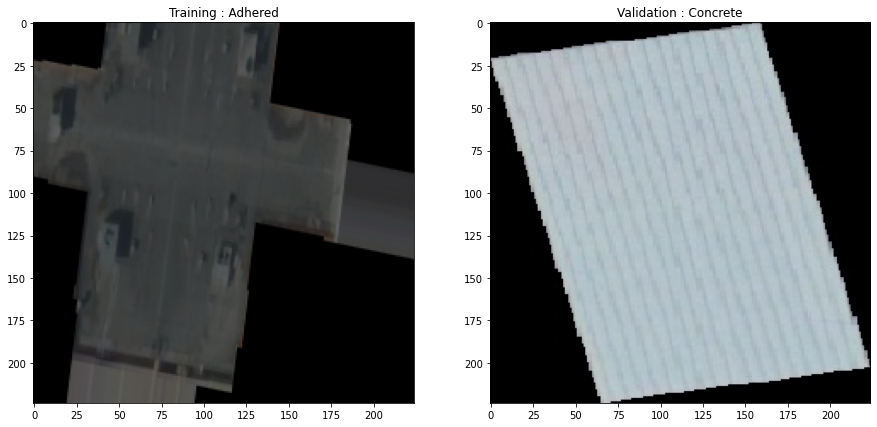

In [15]:
idx = np.random.randint(len(next(train_set)[0]))
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
plt.imshow((next(train_set)[0][idx]));
plt.title(f"Training : {list(classes.keys())[list(next(train_set)[1][idx]).index(1)]}")

plt.subplot(1, 2, 2)
plt.imshow((next(val_set)[0][idx]));
plt.title(f"Validation : {list(classes.keys())[list(next(val_set)[1][idx]).index(1)]}")
plt.show();

# Building a model

In [28]:
def create_model(img_shape = 224, n_classes = 6):

    pmodel = InceptionResNetV2(input_shape = (img_shape, img_shape, 3), include_top = False,
                             weights = 'imagenet')
    layer_count = 0
    untrained_layers = 0
    tlayers = len(list(pmodel.layers))
    print(f"Total layers : {tlayers}")
    # print(f"last layer_name : {list(pmodel.layers)[len(pmodel.layers)-1].name}")
    for layer in pmodel.layers:
        layer_count += 1
        if layer_count > tlayers//2:
            layer.trainable = True
            print(layer.name)
            untrained_layers += 1
        else:
            layer.trainable = False
    print(f"Total Trainable Layers : {untrained_layers}")
    # print(pmodel.name)
    x = GlobalAveragePooling2D()(pmodel.output)
    # x = Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)
    # x = Dropout(0.5)(x)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(inputs = pmodel.input, outputs = output, name = pmodel.name)
    return model

model = create_model()

219062272/219055592 [==============================] - 2s 0us/step
Total layers : 780
conv2d_106
batch_normalization_106
activation_106
conv2d_104
conv2d_107
batch_normalization_104
batch_normalization_107
activation_104
activation_107
block17_8_mixed
block17_8_conv
block17_8
block17_8_ac
conv2d_109
batch_normalization_109
activation_109
conv2d_110
batch_normalization_110
activation_110
conv2d_108
conv2d_111
batch_normalization_108
batch_normalization_111
activation_108
activation_111
block17_9_mixed
block17_9_conv
block17_9
block17_9_ac
conv2d_113
batch_normalization_113
activation_113
conv2d_114
batch_normalization_114
activation_114
conv2d_112
conv2d_115
batch_normalization_112
batch_normalization_115
activation_112
activation_115
block17_10_mixed
block17_10_conv
block17_10
block17_10_ac
conv2d_117
batch_normalization_117
activation_117
conv2d_118
batch_normalization_118
activation_118
conv2d_116
conv2d_119
batch_normalization_116
batch_normalization_119
activation_116
activation_11

In [29]:
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [30]:
plot_model(model, to_file=os.path.join(WORK_DIR, f"{model.name}.png"), show_shapes=True, show_layer_names=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.517941 to fit
tcmalloc: large alloc 1179582464 bytes == 0x56150551e000 @  0x7f9e54262001 0x7f9e504f91fa 0x7f9e504f92ad 0x7f9e516846df 0x7f9e51b7b261 0x7f9e53ff8468 0x7f9e53ffad53 0x5615038a9092 0x7f9e539adbf7 0x5615038a912a



In [31]:
# class_weights = {}
# sum = 0
# for class_ in classes:
#     class_weights[classes[class_]] = 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
#     sum += 1/(len(train_csv[train_csv['1'] == class_])/len(train_csv))
# class_weights

In [32]:
n_epoch = 50

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, 
                              verbose=1, mode='min', min_lr = 1e-7)

model_Best_save = ModelCheckpoint(f"/content/ModelCheckpoints/{model.name}.h5",
                                                    monitor = "val_loss",
                                                    save_weights = True,
                                                    save_best_only = True,
                                                    mode = "min"
                                                    )
LR = 1e-3
model.compile(loss = 'categorical_crossentropy',
            #   loss_weights= class_weights,
              metrics = ['accuracy', 'AUC'],
              optimizer = Adam(lr = LR)
              )

callbacks = [model_Best_save, early_stop, reduce_lr]

In [33]:
training_history = model.fit(train_set,
                             validation_data = val_set,
                             callbacks = callbacks,
                             epochs = n_epoch,
                            #  class_weight = class_weights,
                             verbose = 1)

Epoch 1/50
109/109 [==============================] - 213s 2s/step - loss: 1.2032 - accuracy: 0.5338 - auc: 0.8469 - val_loss: 11.9898 - val_accuracy: 0.3597 - val_auc: 0.6406
Epoch 2/50
109/109 [==============================] - 196s 2s/step - loss: 0.7809 - accuracy: 0.7043 - auc: 0.9383 - val_loss: 0.8074 - val_accuracy: 0.7091 - val_auc: 0.9389
Epoch 3/50
109/109 [==============================] - 196s 2s/step - loss: 0.7051 - accuracy: 0.7350 - auc: 0.9490 - val_loss: 3.4372 - val_accuracy: 0.4453 - val_auc: 0.7326
Epoch 4/50
109/109 [==============================] - 194s 2s/step - loss: 0.6641 - accuracy: 0.7489 - auc: 0.9545 - val_loss: 0.8862 - val_accuracy: 0.7224 - val_auc: 0.9339
Epoch 5/50
109/109 [==============================] - 195s 2s/step - loss: 0.5993 - accuracy: 0.7683 - auc: 0.9630 - val_loss: 0.6852 - val_accuracy: 0.7889 - val_auc: 0.9571
Epoch 6/50
109/109 [==============================] - 195s 2s/step - loss: 0.5670 - accuracy: 0.7893 - auc: 0.9663 - val_los

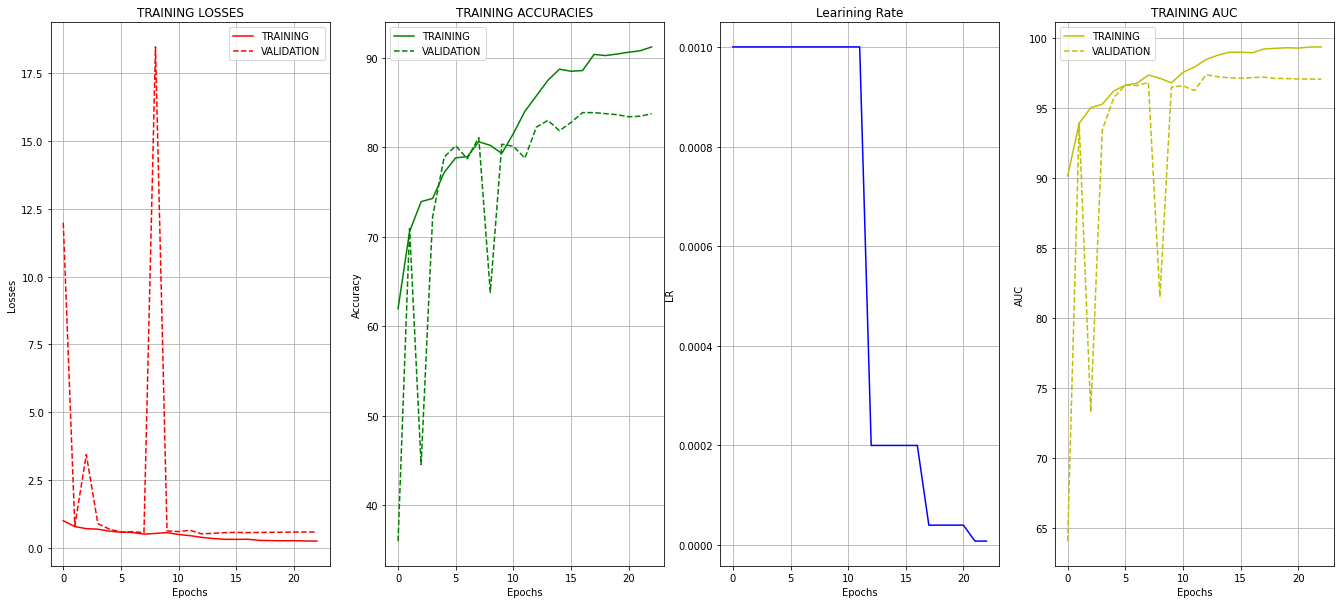

In [43]:
epochs = [d for d in range(len(training_history.history['loss']))]
loss = training_history.history['loss']; val_loss = training_history.history['val_loss']
acc = [d*100 for d in training_history.history['accuracy']]; val_acc = [d*100 for d in training_history.history['val_accuracy']]
auc = [d*100 for d in training_history.history['auc']]; val_auc = [d*100 for d in training_history.history['val_auc']]
lr = training_history.history['lr']

plt.figure(figsize = (23, 10))
plt.subplot(1, 4, 1)
plt.plot(epochs, loss, "-r", )
plt.plot(epochs, val_loss, "--r", )
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING LOSSES")

plt.subplot(1, 4, 2)
plt.plot(epochs, acc, "-g")
plt.plot(epochs, val_acc, "--g")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING ACCURACIES")

plt.subplot(1, 4, 3)
plt.plot(epochs, lr, "-b")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("LR")
plt.title("Learining Rate")

plt.subplot(1, 4, 4)
plt.plot(epochs, auc, "-y")
plt.plot(epochs, val_auc, "--y")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["TRAINING", "VALIDATION"])
plt.title("TRAINING AUC")

plt.savefig(os.path.join(WORK_DIR, f"{model.name}_training_history.png"));
plt.show();

model.save(os.path.join(WORK_DIR, f"{model.name}_{round(val_acc[-1])}.h5"))

# Performing a submission


In [44]:
os.listdir(WORK_DIR)

['attentive_ai_internship_hiring_challenge-dataset.zip',
 'sample_imgs.png',
 'effb0_avg_pretrained.png',
 'train_csv.csv',
 'test_csv.csv',
 'ResNet50_notTrained.png',
 'ResNet50_52.h5',
 'EffNet0_notTrained.png',
 'EffNetB0_training_history.png',
 'EffNetB0_67.09080338478088.h5',
 'EffNet0_preTrained.png',
 'ResNet50_preTrained.png',
 'ResNet50',
 'ResNet50_35.62752902507782.h5',
 'ResNet50_training_history.png',
 'ResNet50.png',
 'resnet50v2.png',
 'Transfer Learning for Optical Satellite Images.pdf',
 'resnet50v2_training_history.png',
 'resnet50v2_83.1116259098053.h5',
 'DockShip_BaseLineModel_InceptionResNetV2.ipynb',
 'efficientnetb4.png',
 'inception_resnet_v2.png',
 'inception_resnet_v2_training_history.png',
 'inception_resnet_v2_83.74783396720886.h5',
 'inception_resnet_v2_84.h5']

In [59]:
sub_model = load_model(os.path.join(WORK_DIR, '/content/ModelCheckpoints/inception_resnet_v2_acc_84.h5'))

In [58]:
!cp ./ModelCheckpoints/inception_resnet_v2_acc_84.h5 ./drive/MyDrive/DockShip_Hiring_Challenge/

In [47]:
sub_model.evaluate(val_set)

28/28 [==============================] - 25s 779ms/step - loss: 0.5071 - accuracy: 0.8224 - auc: 0.9734


[0.5070990920066833, 0.8224407434463501, 0.9734441637992859]

In [48]:
sub_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [49]:
test_imgs = []; train_imgs = []
for img_path in tqdm(test_csv.paths):
    img = cv2.imread(img_path)
    img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img/255.
    test_imgs.append(img)

for img_path in tqdm(train_csv.iloc[:len(test_csv), :].paths):
    img = cv2.imread(img_path)
    img=  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img/255.
    train_imgs.append(img)

test_imgs = np.array(test_imgs)
train_imgs = np.array(train_imgs)

100%|██████████| 596/596 [00:02<00:00, 216.26it/s]


In [50]:
test_imgs.shape, train_imgs.shape

((596, 224, 224, 3), (596, 224, 224, 3))

In [51]:
def giveMeClass(x):
    for key, val in classes.items():
        if val == x:
            return key
    return -1

test_preds = sub_model.predict(test_imgs)
train_preds = sub_model.predict(train_imgs)
tpreds = []
trpreds = []
for test_pred in tqdm(test_preds):
    tpreds.append(np.argmax(test_pred))

for train_pred in tqdm(train_preds):
    trpreds.append(np.argmax(train_pred))

train_check = train_csv.iloc[:len(test_csv), :]

train_check['Model_preds'] = trpreds
train_check['Model_preds'] = train_check['Model_preds'].apply(lambda x: giveMeClass(x))

test_csv['Model_preds'] = tpreds
test_csv['Model_preds'] = test_csv['Model_preds'].apply(lambda x: giveMeClass(x))

100%|██████████| 596/596 [00:00<00:00, 135483.45it/s]


In [52]:
train_check

0                 1  ... kfold       Model_preds
0      0.jpg           Adhered  ...   3.0           Adhered
1      1.jpg           Adhered  ...   1.0           Adhered
2      2.jpg          Concrete  ...   1.0          Concrete
3      3.jpg          Concrete  ...   0.0          Concrete
4      4.jpg  Plastic & fabric  ...   1.0  Plastic & fabric
..       ...               ...  ...   ...               ...
591  591.jpg             Steel  ...   2.0           Adhered
592  592.jpg  Plastic & fabric  ...   0.0  Plastic & fabric
593  593.jpg  Plastic & fabric  ...   1.0  Plastic & fabric
594  594.jpg  Plastic & fabric  ...   1.0  Plastic & fabric
595  595.jpg           Adhered  ...   4.0          Concrete

[596 rows x 6 columns]

In [53]:
test_csv

0        1  ...        img_shape       Model_preds
0      0.jpg  Adhered  ...    (3, 609, 388)         Ballasted
1      1.jpg  Adhered  ...      (3, 90, 43)             Steel
2      2.jpg  Adhered  ...    (3, 211, 365)           Adhered
3      3.jpg  Adhered  ...   (3, 1818, 913)          Concrete
4      4.jpg  Adhered  ...    (3, 433, 105)             Steel
..       ...      ...  ...              ...               ...
591  591.jpg  Adhered  ...  (3, 4080, 3220)  Plastic & fabric
592  592.jpg  Adhered  ...    (3, 635, 682)             Steel
593  593.jpg  Adhered  ...    (3, 117, 284)  Plastic & fabric
594  594.jpg  Adhered  ...    (3, 901, 720)         Ballasted
595  595.jpg  Adhered  ...  (3, 1467, 1013)           Shingle

[596 rows x 5 columns]

In [54]:
print(classification_report(test_csv['1'], test_csv['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       1.00      0.18      0.30       596
       Ballasted       0.00      0.00      0.00         0
        Concrete       0.00      0.00      0.00         0
Plastic & fabric       0.00      0.00      0.00         0
         Shingle       0.00      0.00      0.00         0
           Steel       0.00      0.00      0.00         0

        accuracy                           0.18       596
       macro avg       0.17      0.03      0.05       596
    weighted avg       1.00      0.18      0.30       596



In [55]:
print(classification_report(train_check['1'], train_check['Model_preds']))

                  precision    recall  f1-score   support

         Adhered       0.92      0.84      0.88       366
       Ballasted       0.51      0.95      0.67        19
        Concrete       0.72      0.71      0.71        65
Plastic & fabric       0.78      0.81      0.79        57
         Shingle       0.96      0.74      0.84        35
           Steel       0.55      0.76      0.64        54

        accuracy                           0.81       596
       macro avg       0.74      0.80      0.75       596
    weighted avg       0.84      0.81      0.82       596



In [56]:
submission = test_csv[['0', 'Model_preds']]
submission.rename({'Model_preds': "1"}, axis = 1, inplace = True)
submission.to_csv('output.csv', index = False)
submission

0                 1
0      0.jpg         Ballasted
1      1.jpg             Steel
2      2.jpg           Adhered
3      3.jpg          Concrete
4      4.jpg             Steel
..       ...               ...
591  591.jpg  Plastic & fabric
592  592.jpg             Steel
593  593.jpg  Plastic & fabric
594  594.jpg         Ballasted
595  595.jpg           Shingle

[596 rows x 2 columns]